# Visualization of Crescent City tsunami inundation 

This notebook illustrates how to make some simple plots of geodata using the [matplotlib](http://matplotlib.org/index.html) package.  See the [matplotlib gallery](http://matplotlib.org/gallery.html) for many other examples of how to do things.

The sample data comes from a tsunami simulation of a hypothetical tsunami arising from an earthquake on the Cascadia Subduction Zone hitting Crescent City, CA.  The data set used shows the maximum depth of water at each point on a grid covering part of the harbor during the course of the simulation.  

Many simulations like this are done in order to perform probabilistic tsunami hazard assessment (PTHA).  A set of Jupyter notebooks illustrating how this is done were prepared for a workshop last autumn and also contain some other examples of how to plot data.  These can be found in the Github repository https://github.com/rjleveque/ptha_tutorial.

<img src='figures/800px-Crescent_City_California_harbor_aerial_viewUSArmyCorpofEngineeers1.jpg' width=400>

The following "magic" command makes makes the `matplotlib` plots show up right in the notebook.  If you instead give the command `%matplotlib notebook` then it is also possible to interact with plots, e.g. to zoom.  
See [Jupyter documentation](http://ipython.readthedocs.io/en/stable/interactive/plotting.html)

In [96]:
%matplotlib inline

Import numpy and matplotlib:

In [97]:
import numpy as np
import matplotlib.pyplot as plt

So that this notebook runs with either a Python 2 or Python 3 kernel, use the Python 3 print function rather than the Python 2 print statement:

In [98]:
from __future__ import print_function # in case of Python 2

### Function to read a file in asc format:

There are many tools available in various packages to read geodata in a variety of formats.  Here we provide a simple function to read a file in [ESRI ASCII raster format](http://resources.esri.com/help/9.3/arcgisengine/java/GP_ToolRef/spatial_analyst_tools/esri_ascii_raster_format.htm),
which consists of a header describing the grid followed by values on the grid.

**Note:** The [data_tools.py](data_tools.py) file in this directory contains the same `read_asc_file` function, so we could have just imported from there.

In [99]:
def read_asc_file(file_path, verbose=True):
    import numpy as np
    asc_file = open(file_path, 'r')
    
    tokens = asc_file.readline().split()
    ncols = int(tokens[1])
    
    tokens = asc_file.readline().split()
    nrows = int(tokens[1])
    
    tokens = asc_file.readline().split()
    xllcorner = float(tokens[1])
    
    tokens = asc_file.readline().split()
    yllcorner = float(tokens[1])
    
    tokens = asc_file.readline().split()
    cellsize = float(tokens[1])
    
    tokens = asc_file.readline().split()
    nodata_value = float(tokens[1])
    
    if verbose:
        print( "ncols = %i" % ncols)
        print( "nrows = %i" % nrows)
        print( "xllcorner = %g" % xllcorner)
        print( "yllcorner = %g" % yllcorner)
        print( "cellsize = %g" % cellsize)
        print( "nodata_value = %g" % nodata_value)
        
    # read in all the data, assumed to be on ncols lines, 
    # each containing nrows values
    
    asc_file.close()  # close file so we can load array
    asc_data = np.loadtxt(file_path, skiprows=6)  # skip header
    
    # reshape
    values = asc_data.reshape((nrows,ncols))
    
    # flip in y because of data order
    values = np.flipud(values)    
    
    x = xllcorner + cellsize * np.arange(0,ncols)
    y = yllcorner + cellsize * np.arange(0,nrows)
    
    X,Y = np.meshgrid(x,y)
        
    asc_data_dict = {'ncols': ncols, 'nrows': nrows, 'xllcorner':xllcorner, \
                     'yllcorner':yllcorner, 'cellsize':cellsize, 'nodata_value':nodata_value, \
                     'X': X, 'Y':Y, 'values': values}
    return asc_data_dict

### Read in the data files for this example

First the file containing the maximum water depth hmax:

In [100]:
hmax_file = '../geoclaw_output/hmax_CC.asc'
hmax_data_dict = read_asc_file(hmax_file)

ncols = 146
nrows = 128
xllcorner = -124.215
yllcorner = 41.7349
cellsize = 0.000277793
nodata_value = -9999


Unpack the dictionary that is returned, extracting the grid and `hmax` values:

In [101]:
hmax = hmax_data_dict['values']
X = hmax_data_dict['X']
Y = hmax_data_dict['Y']

Do the same for the file containing topography values.  These values `topo` are the height of the topography at each point relative to some `vertical datum`, in this case Mean High Water (MHW) since this data came from a database of topography DEMs for tsunami inundation.  [Add link!]

In [102]:
topo_file = '../geoclaw_output/topo_CC.asc'
topo_data_dict = read_asc_file(topo_file, verbose=False)

topo = topo_data_dict['values']

### Plot contours of topography

The `X,Y` arrays for the `topo` are the same as for `hmax` (one should check this!)

We can do a quick and dirty plot of contours of topography:

Contour levels: [  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.]


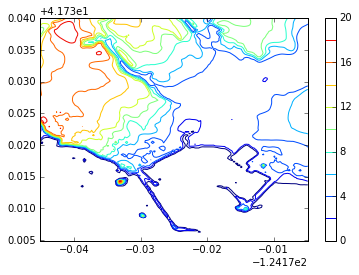

In [103]:
topo_contour_levels = np.arange(0, topo.max()+1, 2)  # 2 meter increments
print( "Contour levels: %s" % topo_contour_levels)
plt.contour(X,Y,topo, topo_contour_levels)
plt.colorbar()

There are several things about this plot that we might want to fix:
 - The ticklabels show only an offset rather than the full latitude longitude,
 - The aspect ratio is not correct.  At latitude theta, one degree of longitude is shorter than one degree of latitude by a factor of $cos(\theta)$.
 - For plotting data on top of the contour plot, we might want all the contour lines to be the same color, say black (which is denoted by `'k'`).

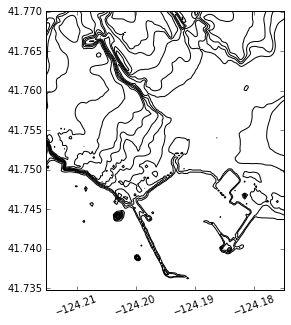

In [104]:
# Create a figure of the desired size:
fig = plt.figure(figsize=(5,5))  
ax = plt.axes()  

plt.contour(X,Y,topo, topo_contour_levels, colors='k')

# set the aspect ratio, converting 41.7 degrees to radians
ax.set_aspect(1./np.cos(41.7*np.pi/180.)) 

# get rid of the offsets:
ax.ticklabel_format(format='plain',useOffset=False)

# rotate the xtick labels so they are readable:
plt.xticks(rotation=20);   # semi-colon to suppress a message

### Plot water depth on contour plot

Here's a first attempt a plotting the maximum water depth data on the contour plot:

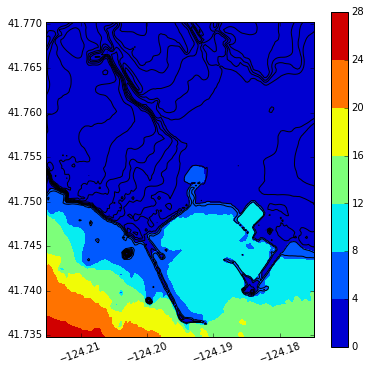

In [105]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes()

plt.contour(X,Y,topo, topo_contour_levels, colors='k')

ax.set_aspect(1./np.cos(41.7*np.pi/180.))
ax.ticklabel_format(format='plain',useOffset=False)
plt.xticks(rotation=20)

# Now plot the data as filled contours:
plt.contourf(X,Y,hmax)
plt.colorbar()

This plot has several problems:
- It is impossible to tell water depth 0 (no inundation) from small depths,
- The colormap and limits were set based on the data, and are revealing deep water offshore, with no information about what's happening onshore.

We can fix this by masking out the `hmax` grid in regions where either the land is dry (e.g. where `hmax < 0.001` meters) and also where `topo < 0`, i.e., anywhere there is water at high tide.

The numpy module `ma` provides masked arrays:

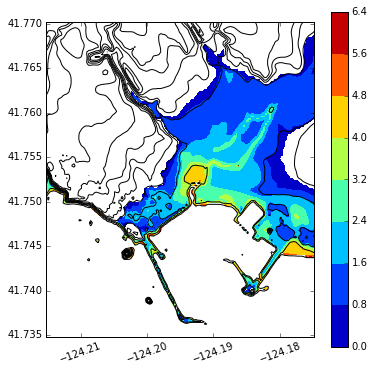

In [106]:
from numpy import ma  # masked arrays

# mask out the dry cells (e.g., where depth < 1 mm):
hmax_dry = ma.masked_where(hmax < 0.001, hmax)

# mask out the water region if we only care about onshore:
hmax_onshore = ma.masked_where(topo < 0, hmax_dry)


fig = plt.figure(figsize=(6,6))
ax = plt.axes()

plt.contour(X,Y,topo, topo_contour_levels, colors='k')

ax.set_aspect(1./np.cos(41.7*np.pi/180.))
ax.ticklabel_format(format='plain',useOffset=False)
plt.xticks(rotation=20)

plt.contourf(X,Y,hmax_onshore)
plt.colorbar()

This gives a more useful plot.

### Custom color maps

We might want to tweak it further, e.g. by specifying the colormap and/or the depth levels separating colors.

Here's a little function that makes a list of colors (as [R,G,B] values):

In [107]:
def discrete_cmap_1(clines):
    """
    Construct a discrete color map for the regions between the contour lines
    given in clines. Colors go from turqouise through yellow to red.
    Good for flooding depth.
    """
    from numpy import floor, linspace, hstack, ones, zeros
    nlines = len(clines)
    n1 = int(floor((nlines-1)/2.))
    n2 = nlines - 1 - n1
    Green = hstack([linspace(1,1,n1),linspace(1,0,n2)])
    Red = hstack([linspace(0,0.8,n1), ones(n2)])
    Blue = hstack([linspace(1,0.2,n1), zeros(n2)])
    colors = zip(Red,Green,Blue)
    return colors

From above we see that the maximum inundation depth is nearly 6 meters, but only in a few regions near the shore.  So we will choose contour levels every 0.5 m up to 4 meters (9 values) and then set `depth_colors` to be a list of 8 [R,G,B] values for the color between each.  

In [108]:
depth_contour_levels = np.arange(0,4.5,0.5)  # every 0.5 m up to 4 m
depth_colors = discrete_cmap_1(depth_contour_levels)

print( "depth_contour_levels = ", depth_contour_levels)
print( "depth_colors = \n",np.array(depth_colors))

depth_contour_levels =  [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4. ]
depth_colors = 
 [[ 0.          1.          1.        ]
 [ 0.26666667  1.          0.73333333]
 [ 0.53333333  1.          0.46666667]
 [ 0.8         1.          0.2       ]
 [ 1.          1.          0.        ]
 [ 1.          0.66666667  0.        ]
 [ 1.          0.33333333  0.        ]
 [ 1.          0.          0.        ]]


Note that we pass the argument `extend='max'` to `contourf` below so that values above 4m also get painted red (rather than white as they otherwise would).  Note that this affects the colorbar as well -- it shows that red extends above 4m.  We also add a title telling the actual maximum depth.

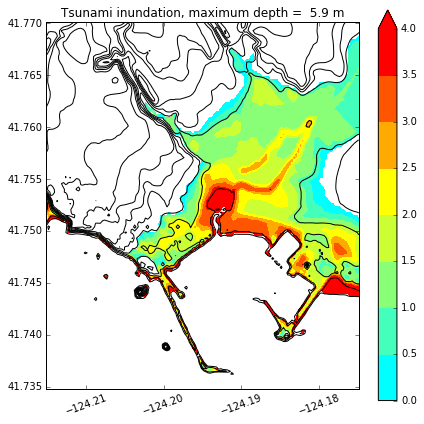

In [109]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes()

plt.contour(X,Y,topo, topo_contour_levels, colors='k')

ax.set_aspect(1./np.cos(41.7*np.pi/180.))
ax.ticklabel_format(format='plain',useOffset=False)
plt.xticks(rotation=20)

plt.contourf(X,Y,hmax_onshore, depth_contour_levels, \
            colors = depth_colors, extend='max')
plt.colorbar()
plt.title('Tsunami inundation, maximum depth = %4.1f m' \
          % hmax_onshore.max());

## Plotting on top of an image

We can also plot the data on top of an image, in this case a screen shot from Google Earth that was carefully chosen to cover exactly the same region as the data files we are plotting.  First we simply read in the image from a png file and show it using `imshow`:

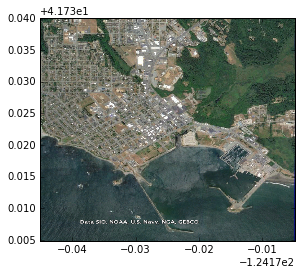

In [110]:
CCimage = plt.imread('figures/CC_GE.png')
image_extent = (X.min(),X.max(),Y.min(),Y.max())  
plt.imshow(CCimage, extent = image_extent)

Now we plot the inundation data on this image.  Note that `alpha` is a transparency value that can range from 0 (fully transparent) to 1 (opaque), allowing us to see the image beneath the `contourf` plot.

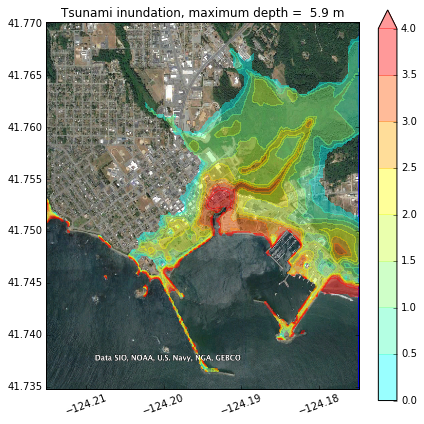

In [111]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes()

plt.imshow(CCimage, extent = (X.min(),X.max(),Y.min(),Y.max()))

ax.set_aspect(1./np.cos(41.7*np.pi/180.))
ax.ticklabel_format(format='plain',useOffset=False)
plt.xticks(rotation=20)

alpha = 0.4
plt.contourf(X,Y,hmax_onshore, depth_contour_levels, \
            colors = depth_colors, extend='max', alpha=alpha)
plt.colorbar()
plt.title('Tsunami inundation, maximum depth = %4.1f m' \
          % hmax_onshore.max());

## pcolor plots

The [pcolor](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.pcolor) and [imshow](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow) may also be useful for plotting pseudo-color plots of topography or data.

A colormap must be specified.  Several are available in the [matplotlib.cm module](http://matplotlib.org/api/cm_api.html#module-matplotlib.cm).  For an illustration of these see 
[matplotlib colormaps reference](http://matplotlib.org/examples/color/colormaps_reference.html).

To define your own color map, see for example [custom cmap examples](http://matplotlib.org/examples/pylab_examples/custom_cmap.html).

Here we just show one example, plotting the topography using the colormap `cm.gist_earth`.


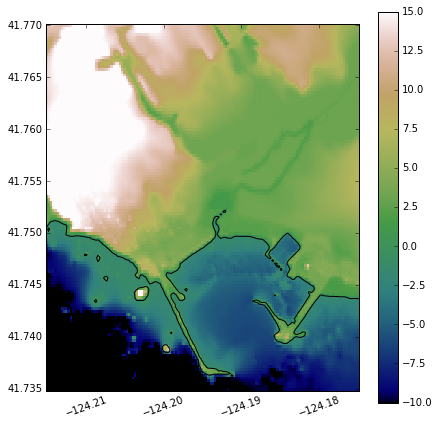

In [112]:
from matplotlib import cm

fig = plt.figure(figsize=(7,7))
ax = plt.axes()

plt.pcolor(X,Y,topo,cmap=cm.gist_earth)
plt.clim(-10,15)
plt.colorbar()

# add shoreline as a contour:
plt.contour(X,Y,topo,[0.],colors='k')  

ax.set_aspect(1./np.cos(41.7*np.pi/180.))
ax.ticklabel_format(format='plain',useOffset=False)
plt.xticks(rotation=20);


You can do fancier things too, such as apply a light source to show hill shading. See also [a more complete example](http://matplotlib.org/examples/specialty_plots/topographic_hillshading.html)

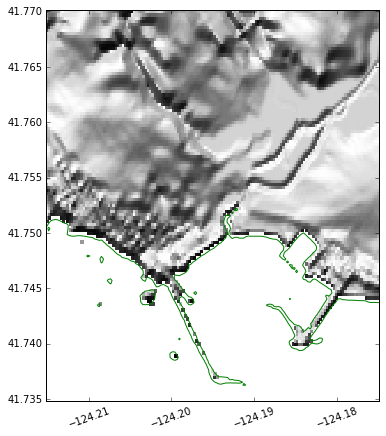

In [113]:
from matplotlib.colors import LightSource

ls = LightSource(azdeg=200, altdeg=45)

fig = plt.figure(figsize=(7,7))
ax = plt.axes()

plt.pcolor(X,Y,ls.hillshade(ma.masked_where(topo<-1,topo), vert_exag=3), cmap='gray')

# add shoreline as a contour:
plt.contour(X,Y,topo,[0.],colors='g')  

ax.set_aspect(1./np.cos(41.7*np.pi/180.))
ax.ticklabel_format(format='plain',useOffset=False)
plt.xticks(rotation=20);

## Interactive map

The [ipyleaflet](https://github.com/ellisonbg/ipyleaflet) package allows creating interactive maps in the notebook.  You can zoom in below to explore Crescent City.

Is it possible to plot our data on this map??

In [114]:
from ipyleaflet import Map

CCmap = Map(center=[41.745, -124.19], zoom=14)
CCmap